In [1]:
import os, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

In [2]:
from random import shuffle
import sys, os
from datetime import datetime, timedelta
import numpy as np , pandas as pd
import time
import joblib
import random

import multiprocessing

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from vae_conv_I_model import VariationalAutoencoderConvInterpretable as VAE_ConvI
from vae_IN_model import VAE_IN as VAE_IN
from config import config as cfg
import utils
import math

In [3]:
sys.path.insert(0, '../../evaluations/disc_and_preds/metrics/')

from discriminative_metrics3 import discriminative_score_metrics
from predictive_metrics3 import predictive_score_metrics
from visualization_metrics import visualization

# Define paths

In [4]:
input_dir = "../../data/processed_orig_data/"
output_dir = "../../data/generated_data/"
model_dir = './model/'
log_dir = './log/'

# Utility Functions

In [5]:
# Set seed for reproducibility
def set_seeds(seed_value):   
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [6]:
def get_train_valid_split(data, valid_perc):
    N = data.shape[0]
    N_train = int(N * (1 - valid_perc))
    N_valid = N - N_train

    # shuffle data, just in case
    np.random.shuffle(data)

    # train, valid split 
    train_data = data[:N_train]
    valid_data = data[N_train:]
    return train_data, valid_data

In [7]:
def scale_train_valid_data(train_data, valid_data): 
    
    _, T, D = train_data.shape
    
    scaler = utils.MinMaxScaler_Feat_Dim( scaling_len = T, input_dim = D, upper_bound = 3.0, lower_bound = -3.0 )        
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_valid_data = scaler.transform(valid_data)
    
    return scaled_train_data, scaled_valid_data, scaler

In [8]:
class MinMaxScaler():
    """Min Max normalizer.
    Args:
    - data: original data

    Returns:
    - norm_data: normalized data
    """
    def fit_transform(self, data): 
        self.fit(data)
        scaled_data = self.transform(data)
        return scaled_data


    def fit(self, data):    
        self.mini = np.min(data, 0)
        self.range = np.max(data, 0) - self.mini
        return self
        

    def transform(self, data):
        numerator = data - self.mini
        scaled_data = numerator / (self.range + 1e-7)
        return scaled_data

    
    def inverse_transform(self, data):
        data *= self.range
        data += self.mini
        return data

In [9]:
def split_list_into_lists(list_of_items, num_splits):
    if len(list_of_items) % num_splits == 0: 
        num_per_split = (len(list_of_items) // num_splits) 
    else: 
        num_per_split = (len(list_of_items) // num_splits) + 1

    list_of_split_lists = []
    for i in range(num_splits):
        list_of_split_lists.append(list_of_items[i * num_per_split : (i + 1) * num_per_split ])
        
    list_of_split_lists = [l for l in list_of_split_lists if l  ]

    return list_of_split_lists

# Main VAE Loop

In [10]:
class PrintLossPerNthEpoch(Callback):
    def __init__(self, label, print_period, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.label = label
        self.print_period = print_period

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.print_period == (self.print_period - 1):
            try:  
                loss = np.round(logs['loss'], 3); val_loss = np.round(logs['val_loss'], 3)
                print( f"{self.label} Avg. train / val loss for epoch {epoch+1}: {loss} / {val_loss} " )
            except: 
                loss = np.round(logs['loss'], 3)
                print( f"{self.label} Avg. train loss for epoch {epoch+1}: {loss} " )
        else: 
            pass

In [11]:
def train_model(model, scaled_train_data, latent_dim, hidden_layer_sizes, reconstruction_wt, epochs = 100):
    
    set_seeds(0)
    _, T, D = scaled_train_data.shape
    

    # ----------------------------------------------------------------------------------------------
    # Instantiate the VAE
    if model == 'vae_conv_I': 
        vae = VAE_ConvI( 
            seq_len=T,  
            feat_dim = D, 
            latent_dim = latent_dim, 
            hidden_layer_sizes=hidden_layer_sizes, 
            reconstruction_wt=reconstruction_wt,
            # trend_poly=1, 
            # num_gen_seas=1,
            # custom_seas = [ (7, 1)] ,     # list of tuples of (num_of_seasons, len_per_season)
            use_residual_conn = True
        )
    else: 
        vae = VAE_ConvI( 
            seq_len=T,  
            feat_dim = int(D), 
            latent_dim = int(latent_dim), 
            hidden_layer_sizes=hidden_layer_sizes, 
            reconstruction_wt=reconstruction_wt,
            trend_poly=2, 
            # num_gen_seas=1,
            custom_seas = [ (4, 1), (6,1), (8,1), (10,1), (12,1) ] ,     # list of tuples of (num_of_seasons, len_per_season)
            use_residual_conn = False
        )

    vae.compile(optimizer=Adam())
    # vae.summary() ; sys.exit()
    
    
    # ----------------------------------------------------------------------------------------------
    # Train the VAE
    early_stop_loss = 'loss'
    early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=50) 
    reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)
    printCB = PrintLossPerNthEpoch(label='TimeVAE', print_period=50)
    
    history = vae.fit(
        scaled_train_data, 
        batch_size = 32,
        epochs=epochs,
        shuffle = True,
        callbacks=[early_stop_callback, reduceLR, printCB],
        verbose = 0
    )
    # ----------------------------------------------------------------------------------------------
    return vae, history

In [12]:
def get_latent_dim(data): 
    sz = data.shape[0] * data.shape[-1]    
    latent_dim = max(1, 1 + int(round(math.log(sz / 500, 2), 0)))    
    return latent_dim

In [13]:
def evaluate_samples2(scaled_ori_data, scaled_gen_data, predictor = 'conv', pred_epochs = 500, disc_epochs = 500):
    
    pred_score = predictive_score_metrics(scaled_ori_data, scaled_gen_data, 
                                         predictor = 'conv', # conv, rnn, nbeats
                                         epochs = pred_epochs, )      

    # disc_score = discriminative_score_metrics(scaled_ori_data, scaled_gen_data,  epochs = disc_epochs)
    disc_score = -1    
    return pred_score, disc_score

In [14]:
valid_perc = 0.


dataset_names = ['sine', 'stocks', 'stocks2', 'air', 'energy']
percs = [2, 5, 10, 20, 100]

main_start_time = time.time()    

for data_name in dataset_names:    
    for p in percs:  
        
        # file name to load
        fname = f'{input_dir + data_name}_subsampled_train_perc_{p}.npz'
        
        # read data        
        loaded = np.load(fname)
        data = loaded['data']       
        N, T, D = data.shape     
#         print(fname, data.shape)      
        
        # perform train/valid split
        train_data, valid_data = get_train_valid_split(data, valid_perc)        
#         print("train/valid shapes: ", train_data.shape, valid_data.shape)            
        
        # scale data 
        scaled_train_data, scaled_valid_data, scaler = scale_train_valid_data(train_data, valid_data)  
        
        # important hyper-parameter!!!
        latent_dim = get_latent_dim(scaled_train_data)
        print(data_name, p, latent_dim)
        
        

sine 2 2
sine 5 3
sine 10 4
sine 20 5
sine 100 8
stocks 2 1
stocks 5 2
stocks 10 3
stocks 20 4
stocks 100 6
stocks2 2 1
stocks2 5 2
stocks2 10 3
stocks2 20 4
stocks2 100 7
air 2 3
air 5 5
air 10 6
air 20 7
air 100 9
energy 2 5
energy 5 7
energy 10 8
energy 20 9
energy 100 11


In [15]:
def generate_vae_data(params, split_num): 
    # set random gen seed for reproducibiity
    set_seeds(42)
    
    data_name = params[0]
    p = params[1]
    
    
    # file name to load
    fname = f'{input_dir + data_name}_subsampled_train_perc_{p}.npz'

    # read data        
    loaded = np.load(fname)
    ori_data = loaded['data']       
    N, T, D = ori_data.shape     
    print(fname, ori_data.shape)    

    scaler = MinMaxScaler()          
#     scaler = utils.MinMaxScaler_Feat_Dim( scaling_len = T, input_dim = D, upper_bound = 3.0, lower_bound = -3.0 ) 
    scaled_ori_data = scaler.fit_transform(ori_data)

    # -------------------------------------------------------------------------
    # hyper-parameters
    latent_dim = hyper_params[data_name]['latent_dim']
    hidden_layer_sizes = hyper_params[data_name]['hidden_layer_sizes']
    reconstruction_wt = hyper_params[data_name]['reconstruction_wt']
    print(latent_dim, hidden_layer_sizes, reconstruction_wt) #; sys.exit()
    # -------------------------------------------------------------------------

    training_times = []
    for t in range(num_iters):
        print("-"*60)
        print(f"Running dataset = {data_name}, perc = {p}, iter = {t} on split {split_num}")

        # start timer
        start = time.time() 
        try: 
            vae, history = train_model(model, scaled_ori_data, 
                                       latent_dim, 
                                       hidden_layer_sizes, 
                                       reconstruction_wt = reconstruction_wt, 
                                       epochs = 2000)
        except e: 
            raise Exception(e)
        

        # stop timer and log training time 
        end = time.time()
        train_time = np.round((end - start)/60.0, 2)

        training_times.append({
            'model': model, 'data': data_name,  'perc': p, 'iter': t, 
            'latent_dim': latent_dim,
            'loss': np.round(history.history['loss'][-1], 3), 
            'reconst_loss': np.round(history.history['reconstruction_loss'][-1],3), 
            'kl_loss': np.round(history.history['kl_loss'][-1], 3), 
            'train_time_in_min': train_time,                
        })            
        # ----------------------------------------------------------------------------------------------
        # Save the model 
        model_name_pref = f'{model}_{data_name}_perc_{p}_iter_{t}_'
        vae.save(model_dir, model_name_pref)  
    
    
    # ----------------------------------------------------------------------------------------------        
    # Generate samples   
    # We will save samples from the last iteration 
#         samples = vae.get_prior_samples(num_samples=int(N * (100 / p)))
    scaled_samples = vae.get_prior_samples(num_samples= ori_data.shape[0])
    #print("gen sample size: ", scaled_samples.shape)

    # inverse transform using scaler 
    samples = scaler.inverse_transform(scaled_samples)        

    # save to output dir
    samples_fpath = f'{model}/{model}_gen_samples_{data_name}_perc_{p}.npz'        
    np.savez_compressed(os.path.join( output_dir, samples_fpath), data=samples)
    # ----------------------------------------------------------------------------------------------        
    # log training times for the iterations
    log_df = pd.DataFrame.from_dict(training_times)
    print(log_df)
    log_file = f'{model}_{data_name}_perc_{p}_train_log.csv'
    log_df.to_csv(log_dir + log_file, index=False)

In [16]:
def generate_all_data(params_sublist, split_num): 
    num = len(params_sublist)
    for i, params in enumerate(params_sublist): 
        generate_vae_data(params, split_num)
        print(f"completed {i+i} of {num}")

In [41]:
l1_mult, l2_mult, l3_mult = 25, 25, 50
# probably best: 3, 1, 2, 3, 1.96

hyper_params = {
    'stocks':   { 
        'latent_dim': 8 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 3.0,
    },
    'stocks2':  { 
        'latent_dim': 8 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 3.0,
    },
    'air':      { 
        'latent_dim': 8 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 3.0,
    },
    'sine':     { 
        'latent_dim': 8 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 3.0,
    },
    'energy':   { 
        'latent_dim': 8 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 3.0,
    },
}

hyper_params = {
    'stocks':   { 
        'latent_dim': 2 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 1.96,   # 1.96
    },
    'stocks2':  { 
         # 1, [2, 4, 4], 1.5
        'latent_dim': 2 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 2.5,   # 1.96
    },
    'air':      { 
        # 4, [2, 4, 4], 2.5
        'latent_dim': 4 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 2.5,   
    },
    'sine':     { 
        'latent_dim': 10 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 2.93,
    },
    'energy':   { 
        'latent_dim': 10 , 
        'hidden_layer_sizes': [2 * l1_mult, 4 * l2_mult, 4 * l3_mult],
        'reconstruction_wt': 0.8,
    },
}

hyper_params['stocks2']

{'latent_dim': 2,
 'hidden_layer_sizes': [50, 100, 200],
 'reconstruction_wt': 1.5}

In [39]:

main_start_time = time.time() 


# how many times to run each scenario
num_iters = 1

# set 10% off for validation during VAE model development; then set to 0 for final data generation
valid_perc = 0.0

# our model name
model = 'vae_conv_I'         # vae_conv_I, vae_IN

dataset_names = ['stocks', 'stocks2', 'air', 'sine', 'energy']
percs = [2, 5, 10, 20, 100]


# to custom run specific data
dataset_names = [ 'stocks2']
# percs = [ 20 ]


params_list = [ [data_name, p ] for data_name in dataset_names for p in percs  ]

# Get cpu_count and use all but one for resource calculations
num_cpus_to_use = multiprocessing.cpu_count() - 2
if num_cpus_to_use > 8: num_cpus_to_use = 8
if len(params_list) < num_cpus_to_use: num_cpus_to_use = len(params_list)
    
# num_cpus_to_use = 1
print(f"Using {num_cpus_to_use} CPUs")

# print(len(params_list))

if num_cpus_to_use == 1: 
    generate_all_data(params_list, 0)    
else: 
    random.shuffle(params_list)
    
    split_params_lists = split_list_into_lists(params_list, num_cpus_to_use)
    
#     print(split_params_lists)   ; sys.exit()

    num_cpus_to_use = len(split_params_lists)
    
    pool = multiprocessing.Pool(num_cpus_to_use)

    # run forecasts on each thread
    for split_num in range(num_cpus_to_use):
        
        pool.apply_async(generate_all_data, 
        args=( split_params_lists[split_num], split_num) )

    pool.close()
    pool.join() 


end = time.time()
elapsed_time = np.round((end - main_start_time)/60.0, 2)
print(f"All done in {elapsed_time} minutes!")  

Using 5 CPUs
../../data/processed_orig_data/stocks2_subsampled_train_perc_5.npz (173, 24, 6)
../../data/processed_orig_data/stocks2_subsampled_train_perc_2.npz (54, 24, 6)
../../data/processed_orig_data/stocks2_subsampled_train_perc_10.npz (370, 24, 6)
2 [50, 100, 200] 2.5
2 [50, 100, 200] 2.5
../../data/processed_orig_data/stocks2_subsampled_train_perc_20.npz (764, 24, 6)
------------------------------------------------------------
2 [50, 100, 200] 2.5
------------------------------------------------------------
Running dataset = stocks2, perc = 2, iter = 0 on split 3
Running dataset = stocks2, perc = 5, iter = 0 on split 2
------------------------------------------------------------
Running dataset = stocks2, perc = 10, iter = 0 on split 0
2 [50, 100, 200] 2.5
------------------------------------------------------------
Running dataset = stocks2, perc = 20, iter = 0 on split 4
../../data/processed_orig_data/stocks2_subsampled_train_perc_100.npz (3919, 24, 6)
2 [50, 100, 200] 2.5
----

Process ForkPoolWorker-43:
Process ForkPoolWorker-44:
Process ForkPoolWorker-41:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/an

KeyboardInterrupt: 

# Load generated data for Inspection

(1000, 24, 5)
generated mean :  [0.50008154 0.4999461  0.5007969  0.5004554  0.5016425 ]


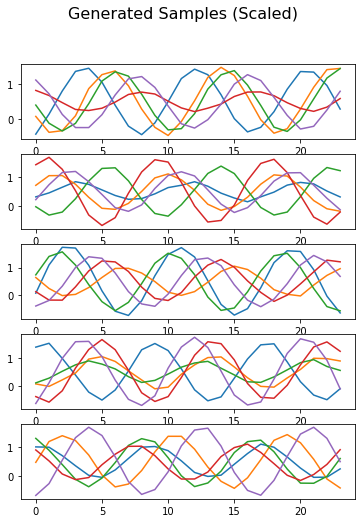

In [19]:
test_data = 'sine'
test_perc = 10

samples_fpath = f'{model}/{model}_gen_samples_{test_data}_perc_{test_perc}.npz'     
loaded = np.load(os.path.join( output_dir, samples_fpath))
gen_data = loaded['data']
print(gen_data.shape)

print("generated mean : ", gen_data.mean(axis=0).mean(axis=0)) 

utils.plot_samples(gen_data, n=5)